In [40]:
import os
import PIL
import time
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from diffusers import (
    ControlNetModel,
    DiffusionPipeline, 
    UniPCMultistepScheduler,
    StableDiffusionInpaintPipeline,
)

from diffusers.utils import load_image

from transformers import (
    CLIPFeatureExtractor, CLIPModel, 
    AutoImageProcessor, UperNetForSemanticSegmentation
)


from clip_interrogator import (
    Config,
    Interrogator
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
!nvidia-smi

Wed Apr 12 19:52:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 30%   34C    P8    18W / 350W |     20MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:41:00.0 Off |                  N/A |
| 32%   

In [36]:
!ls ../data/test_cases

cloth_0.png  image_0.png  masked_image_0.png  warped_cloth_mask_0.png
cloth_1.png  image_1.png  masked_image_1.png  warped_cloth_mask_1.png
cloth_2.png  image_2.png  masked_image_2.png  warped_cloth_mask_2.png
cloth_3.png  image_3.png  masked_image_3.png  warped_cloth_mask_3.png
cloth_4.png  image_4.png  masked_image_4.png  warped_cloth_mask_4.png


## Reverse CLIP embedding

In [38]:
ci = Interrogator(Config(clip_model_name="ViT-H-14/laion2b_s32b_b79k"))

Loading BLIP model...
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth
Loading CLIP model...
Loaded CLIP model and data in 17.95 seconds.


In [39]:
cloth_descriptions = []
for i in range(5):
    start_time = time.time()
    dress = Image.open(f"../data/test_cases/cloth_{i}.png").resize((512, 512))
    descr = ci.interrogate(dress)
    print(i, descr, "time taken: ", time.time() - start_time)
    cloth_descriptions.append(descr)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 232.93it/s]


0 a grey t - shirt with a logo on the chest, inspired by Alberto Giacometti, closed hands, 5 5 yo, philippe starck, highlydetailed, zellk, woodland, tomboy, listing image, waxy, h 7 0 4, zawadzki, hot topic, f / 2 2, toast, 144p


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 245.78it/s]


1 a women's pink t - shirt on a white background, minna sundberg, myminifactory, bench, :6, zawadzki, new classic, alice, 50, commander, denim, close-up product photo, n4, manuka, abcdefghijklmnopqrstuvwxyz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 224.72it/s]


2 a black and white striped turtle neck sweater, mork borg, femme, frontal picture, detailed screenshot, sport t-shirt, practical, triumph, hut, waneella, springs, t - shirt, accessories, canyon, t-shirt


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 226.73it/s]


3 a blue top with a tie around the waist, bump map, listing image, navy, tunic, product image, violet, abcdefghijklmnopqrstuvwxyz, ja mong, tan, 6 4 0, 360, 1 4 8 0 s, 0, geo, thumbnail, general, gui, tuba, set in 19xx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 217.95it/s]

4 a women's white t - shirt with yellow stripes, foil effect, ascii, laurie, cg original, alter, easy, munkácsy, pieces, frontal picture


## StableDiffusionInpaintPipeline

In [41]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

a grey t - shirt with a logo on the chest, inspired by Alberto Giacometti, closed hands, 5 5 yo, philippe starck, highlydetailed, zellk, woodland, tomboy, listing image, waxy, h 7 0 4, zawadzki, hot topic, f / 2 2, toast, 144p


  0%|          | 0/50 [00:00<?, ?it/s]

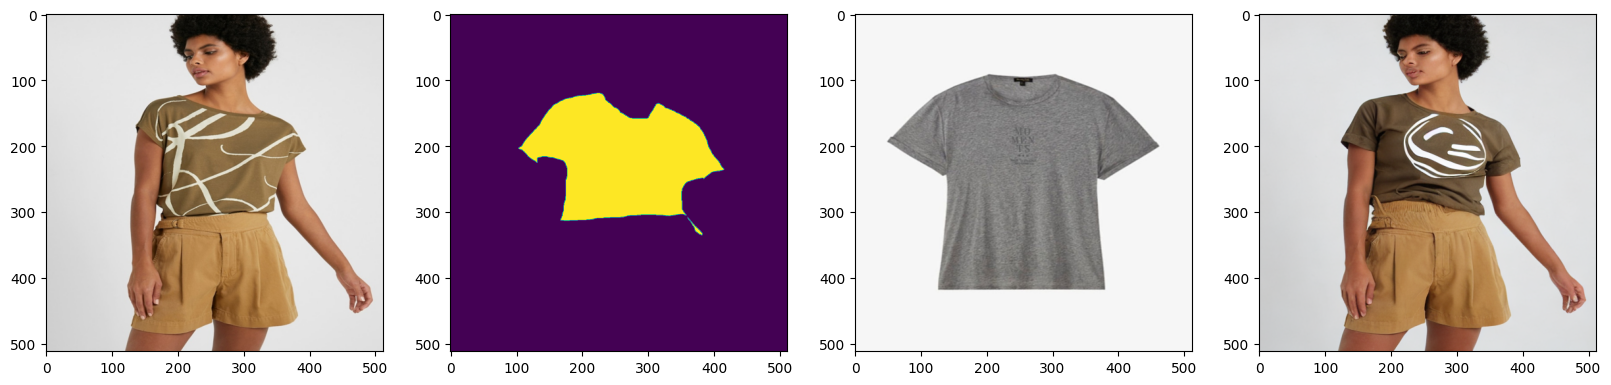

a women's pink t - shirt on a white background, minna sundberg, myminifactory, bench, :6, zawadzki, new classic, alice, 50, commander, denim, close-up product photo, n4, manuka, abcdefghijklmnopqrstuvwxyz


  0%|          | 0/50 [00:00<?, ?it/s]

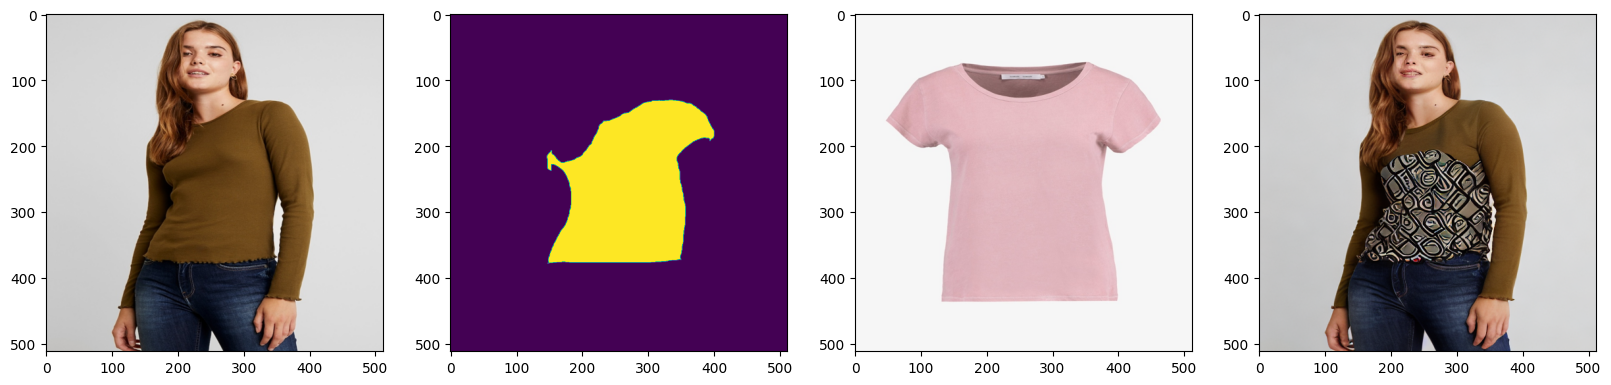

a black and white striped turtle neck sweater, mork borg, femme, frontal picture, detailed screenshot, sport t-shirt, practical, triumph, hut, waneella, springs, t - shirt, accessories, canyon, t-shirt


  0%|          | 0/50 [00:00<?, ?it/s]

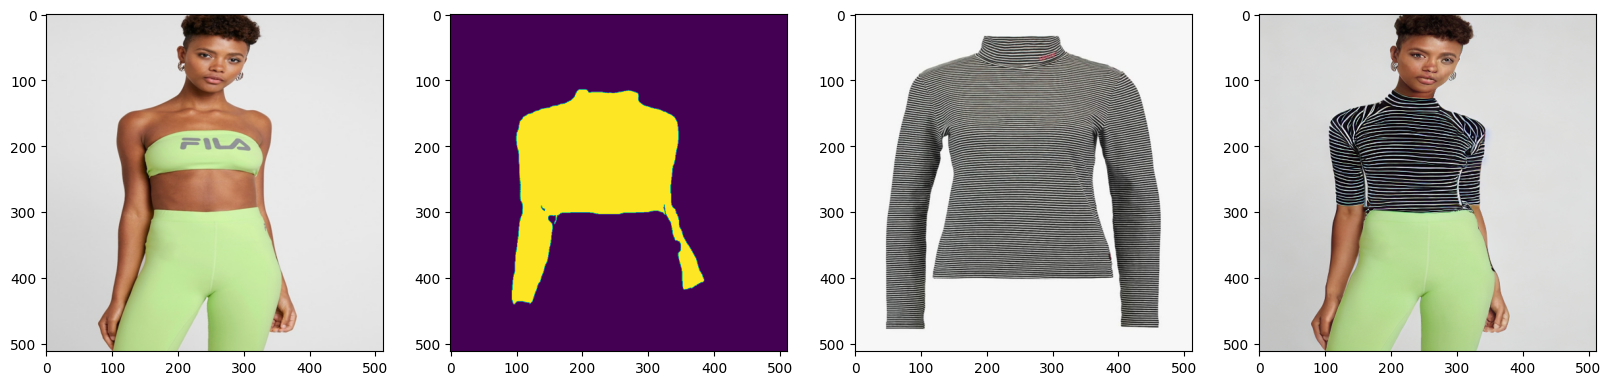

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['9 xx']


a blue top with a tie around the waist, bump map, listing image, navy, tunic, product image, violet, abcdefghijklmnopqrstuvwxyz, ja mong, tan, 6 4 0, 360, 1 4 8 0 s, 0, geo, thumbnail, general, gui, tuba, set in 19xx


  0%|          | 0/50 [00:00<?, ?it/s]

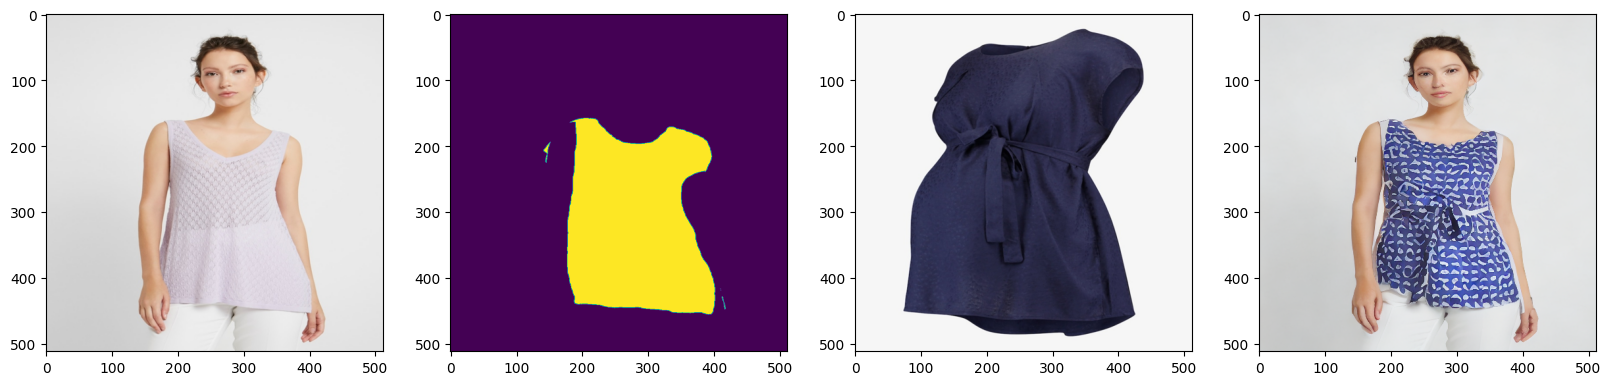

a women's white t - shirt with yellow stripes, foil effect, ascii, laurie, cg original, alter, easy, munkácsy, pieces, frontal picture


  0%|          | 0/50 [00:00<?, ?it/s]

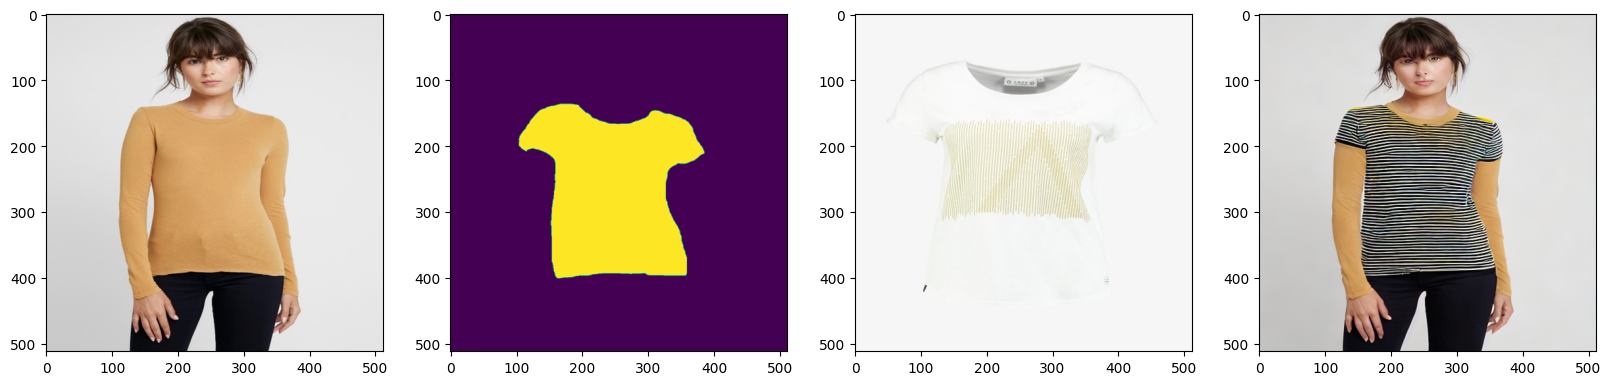

In [46]:
for i in range(5):
    image = Image.open(f"../data/test_cases/image_{i}.png").resize((512, 512))
    mask = Image.open(f"../data/test_cases/warped_cloth_mask_{i}.png").resize((512, 512))
    prompt = cloth_descriptions[i]
    print(prompt)
    res_image = pipe(prompt=prompt, image=image, mask_image=mask).images[0]
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 16))
    ax[0].imshow(image)
    ax[1].imshow(mask)
    ax[2].imshow(Image.open(f"../data/test_cases/cloth_{i}.png").resize((512, 512)))
    ax[3].imshow(res_image)
    plt.show()

## StableDiffusionInpaintPipeline with ControlNet

In [47]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-seg",
)

pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    custom_pipeline="stable_diffusion_controlnet_inpaint",
    controlnet=controlnet
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-convnext-small")

In [19]:
image_segmentor = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-small")

In [21]:
def ade_palette():
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
                        [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
                        [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
                        [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
                        [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
                        [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
                        [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
                        [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
                        [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
                        [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
                        [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
                        [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
                        [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
                        [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
                        [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
                        [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
                        [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
                        [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
                        [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
                        [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
                        [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
                        [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
                        [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
                        [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
                        [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
                        [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
                        [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
                        [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
                        [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
                        [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
                        [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
                        [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
                        [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
                        [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
                        [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
                        [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
                        [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
                        [102, 255, 0], [92, 0, 255]]
    
def image_to_seg(image):
    pixel_values = image_processor(image, return_tensors="pt").pixel_values
    with torch.no_grad():
        outputs = image_segmentor(pixel_values)
    seg = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)  # height, width, 3
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    color_seg = color_seg.astype(np.uint8)
    seg_image = Image.fromarray(color_seg)
    
    return seg_image

In [12]:
image = load_image(
    "https://github.com/CompVis/latent-diffusion/raw/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
)

In [13]:
mask_image = load_image(
    "https://github.com/CompVis/latent-diffusion/raw/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
)

In [24]:
controlnet_conditioning_image = image_to_seg(image)

In [28]:
image = pipe("Face of a yellow cat, high resolution, sitting on a park bench",
            image,
            mask_image,
            controlnet_conditioning_image,
            num_inference_steps=20,
).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

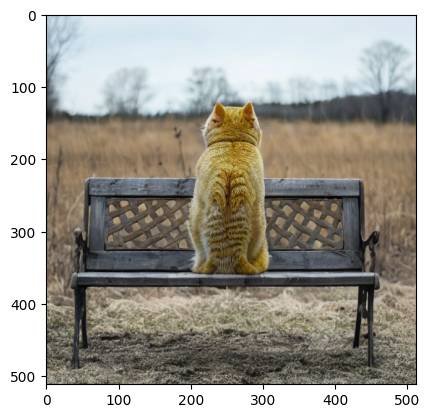

In [29]:
plt.imshow(image)

In [52]:
np.unique(mask)

array([  0,   1,   4,   5,   6,   7,   9,  10,  11,  12,  13,  16,  17,
        18,  19,  21,  22,  23,  34,  35,  38,  40,  42,  52,  53,  71,
        77,  78,  80,  82,  83,  84,  85,  86,  87,  88,  89,  91,  92,
        95,  96,  98, 105, 121, 122, 128, 133, 155, 157, 158, 159, 160,
       161, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 175, 177,
       178, 180, 184, 202, 203, 206, 209, 213, 215, 217, 220, 221, 232,
       233, 234, 236, 237, 238, 239, 242, 243, 244, 245, 246, 248, 249,
       250, 251, 252, 254, 255], dtype=uint8)

a grey t - shirt with a logo on the chest, inspired by Alberto Giacometti, closed hands, 5 5 yo, philippe starck, highlydetailed, zellk, woodland, tomboy, listing image, waxy, h 7 0 4, zawadzki, hot topic, f / 2 2, toast, 144p


  0%|          | 0/20 [00:00<?, ?it/s]

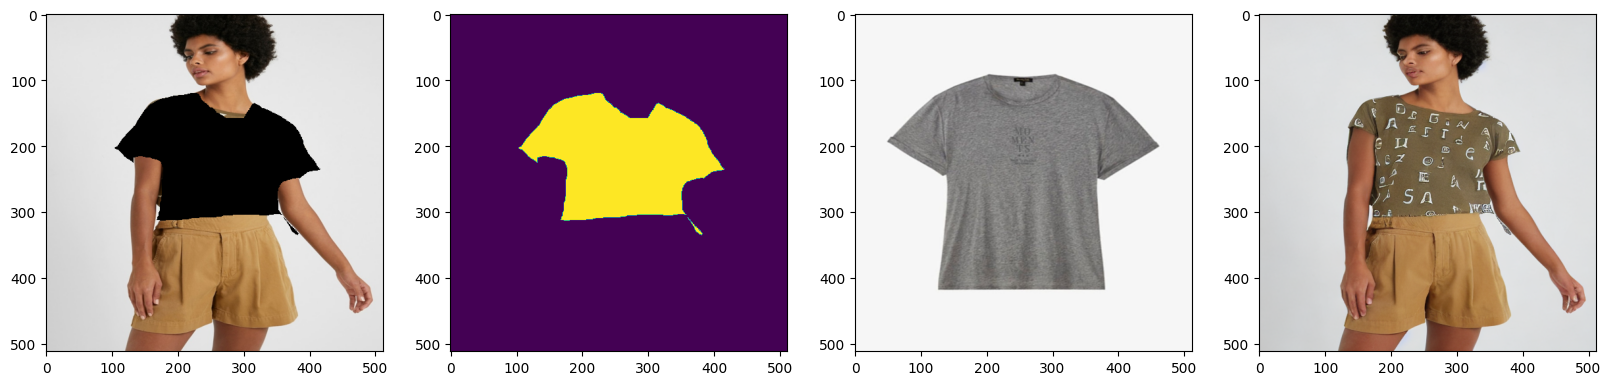

a women's pink t - shirt on a white background, minna sundberg, myminifactory, bench, :6, zawadzki, new classic, alice, 50, commander, denim, close-up product photo, n4, manuka, abcdefghijklmnopqrstuvwxyz


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


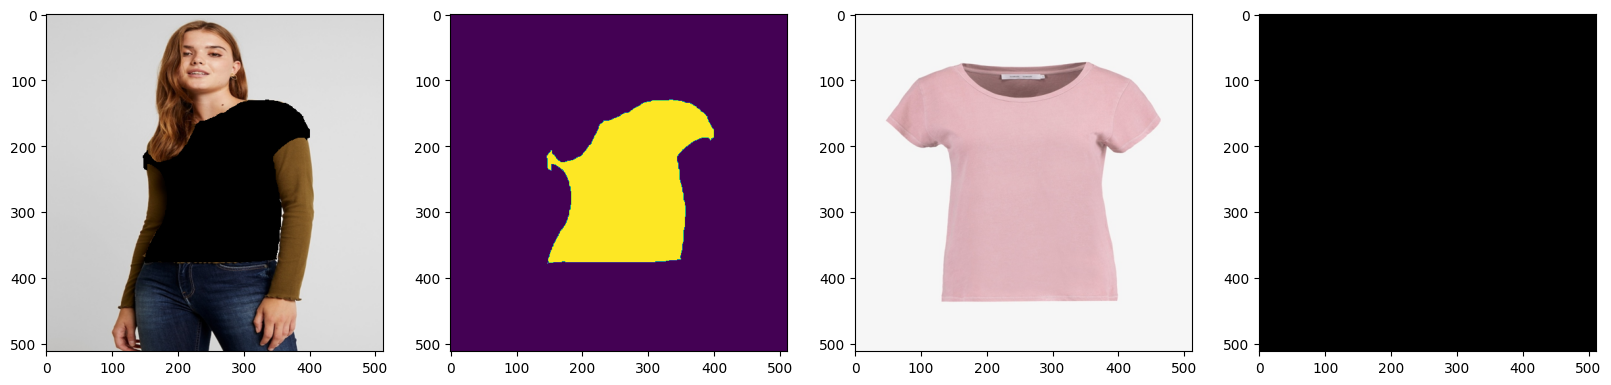

a black and white striped turtle neck sweater, mork borg, femme, frontal picture, detailed screenshot, sport t-shirt, practical, triumph, hut, waneella, springs, t - shirt, accessories, canyon, t-shirt


  0%|          | 0/20 [00:00<?, ?it/s]

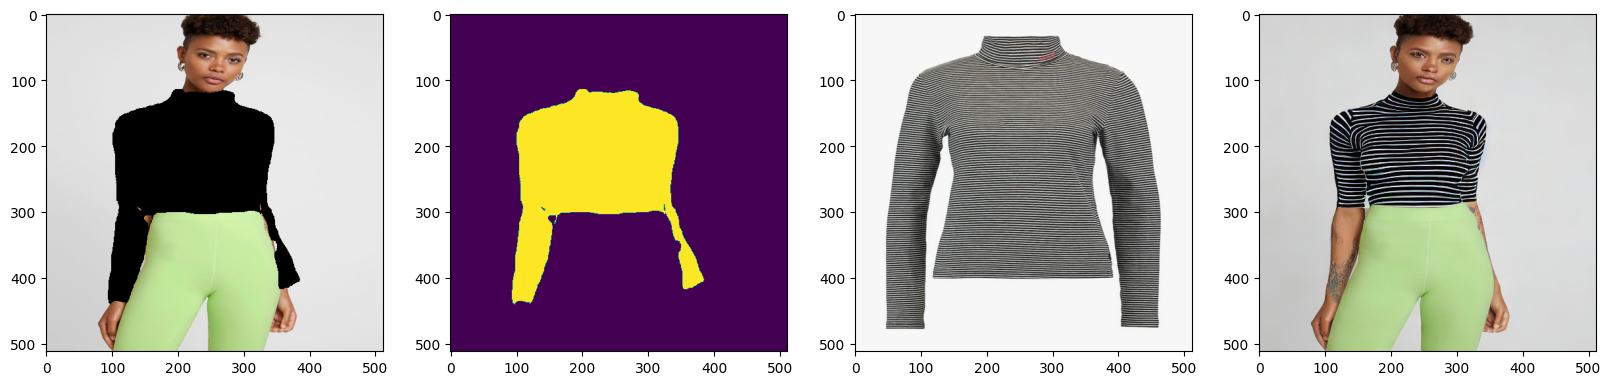

a blue top with a tie around the waist, bump map, listing image, navy, tunic, product image, violet, abcdefghijklmnopqrstuvwxyz, ja mong, tan, 6 4 0, 360, 1 4 8 0 s, 0, geo, thumbnail, general, gui, tuba, set in 19xx


  0%|          | 0/20 [00:00<?, ?it/s]

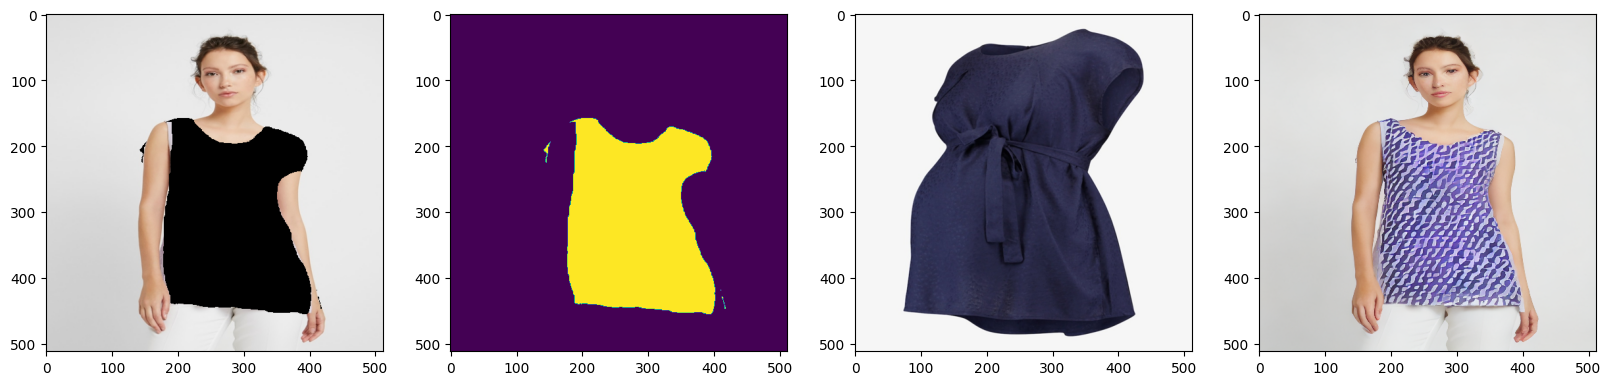

a women's white t - shirt with yellow stripes, foil effect, ascii, laurie, cg original, alter, easy, munkácsy, pieces, frontal picture


  0%|          | 0/20 [00:00<?, ?it/s]

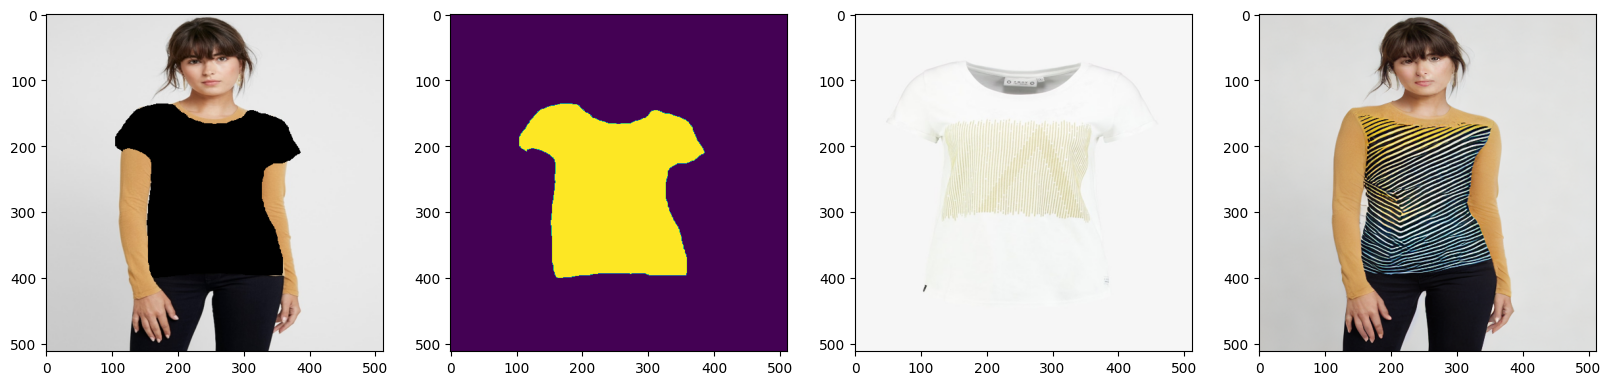

In [53]:
for i in range(5):
    image = Image.open(f"../data/test_cases/image_{i}.png").resize((512, 512))
    mask = Image.open(f"../data/test_cases/warped_cloth_mask_{i}.png").resize((512, 512), Image.NEAREST)
    prompt = cloth_descriptions[i]
    print(prompt)
    controlnet_conditioning_image = image_to_seg(image)
    
    image = np.array(image)
    image[np.array(mask) != 0] = 0
    image = Image.fromarray(image)
    
    res_image = pipe(prompt, image, mask, controlnet_conditioning_image, num_inference_steps=20).images[0]
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 16))
    ax[0].imshow(image)
    ax[1].imshow(mask)
    ax[2].imshow(Image.open(f"../data/test_cases/cloth_{i}.png").resize((512, 512)))
    ax[3].imshow(res_image)
    plt.show()

## StableDiffusionControlNetInpaintImg2ImgPipeline

In [54]:
from diffusers import DiffusionPipeline
from diffusers import ControlNetModel, UniPCMultistepScheduler
from transformers import CLIPFeatureExtractor, CLIPModel

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-seg",
)

pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    custom_pipeline="stable_diffusion_controlnet_inpaint_img2img",
    controlnet=controlnet
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [32]:
image = pipe("Face of a yellow cat, high resolution, sitting on a park bench",
            image,
            mask_image,
            controlnet_conditioning_image,
            num_inference_steps=20,
).images[0]

  0%|          | 0/16 [00:00<?, ?it/s]

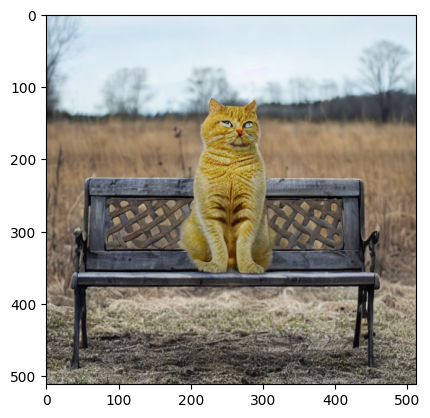

In [33]:
plt.imshow(image)

a grey t - shirt with a logo on the chest, inspired by Alberto Giacometti, closed hands, 5 5 yo, philippe starck, highlydetailed, zellk, woodland, tomboy, listing image, waxy, h 7 0 4, zawadzki, hot topic, f / 2 2, toast, 144p


  0%|          | 0/16 [00:00<?, ?it/s]

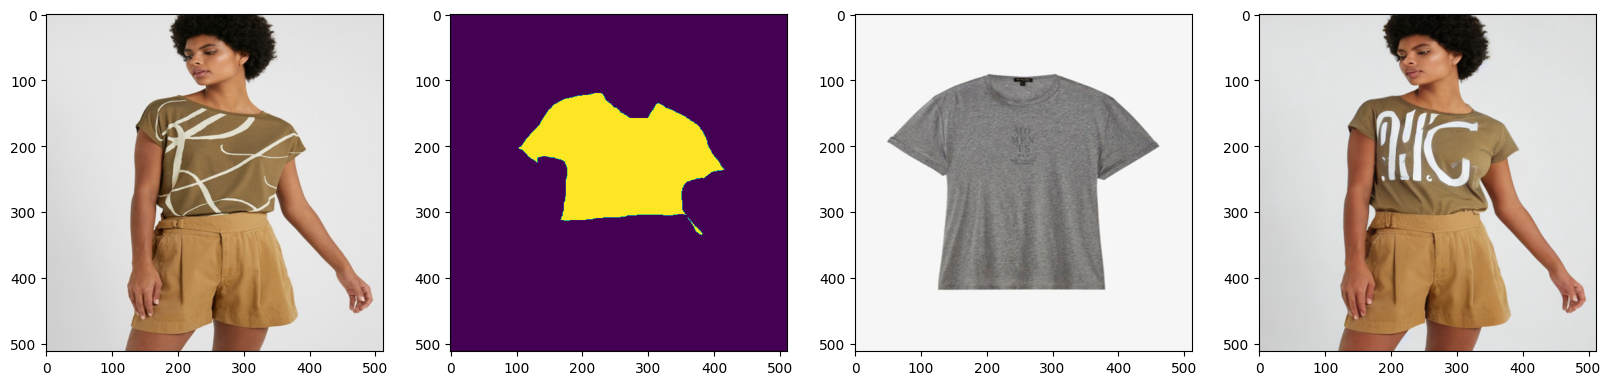

a women's pink t - shirt on a white background, minna sundberg, myminifactory, bench, :6, zawadzki, new classic, alice, 50, commander, denim, close-up product photo, n4, manuka, abcdefghijklmnopqrstuvwxyz


  0%|          | 0/16 [00:00<?, ?it/s]

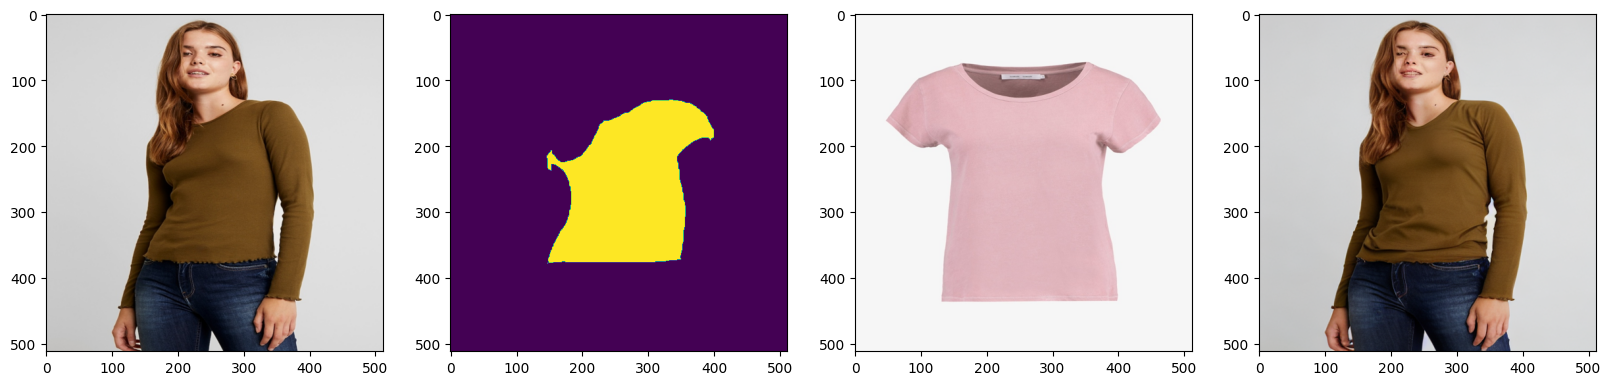

a black and white striped turtle neck sweater, mork borg, femme, frontal picture, detailed screenshot, sport t-shirt, practical, triumph, hut, waneella, springs, t - shirt, accessories, canyon, t-shirt


  0%|          | 0/16 [00:00<?, ?it/s]

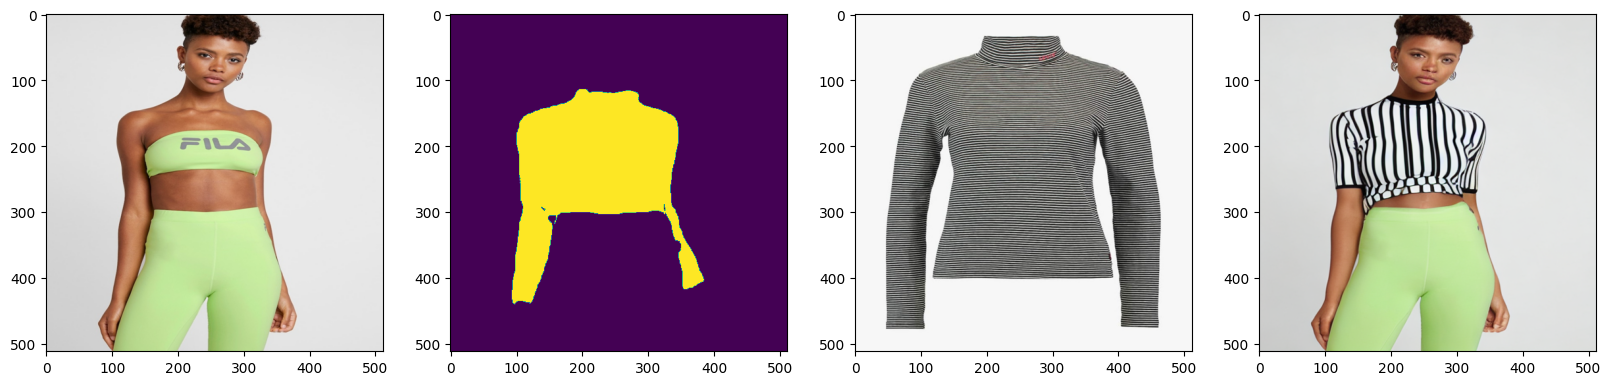

a blue top with a tie around the waist, bump map, listing image, navy, tunic, product image, violet, abcdefghijklmnopqrstuvwxyz, ja mong, tan, 6 4 0, 360, 1 4 8 0 s, 0, geo, thumbnail, general, gui, tuba, set in 19xx


  0%|          | 0/16 [00:00<?, ?it/s]

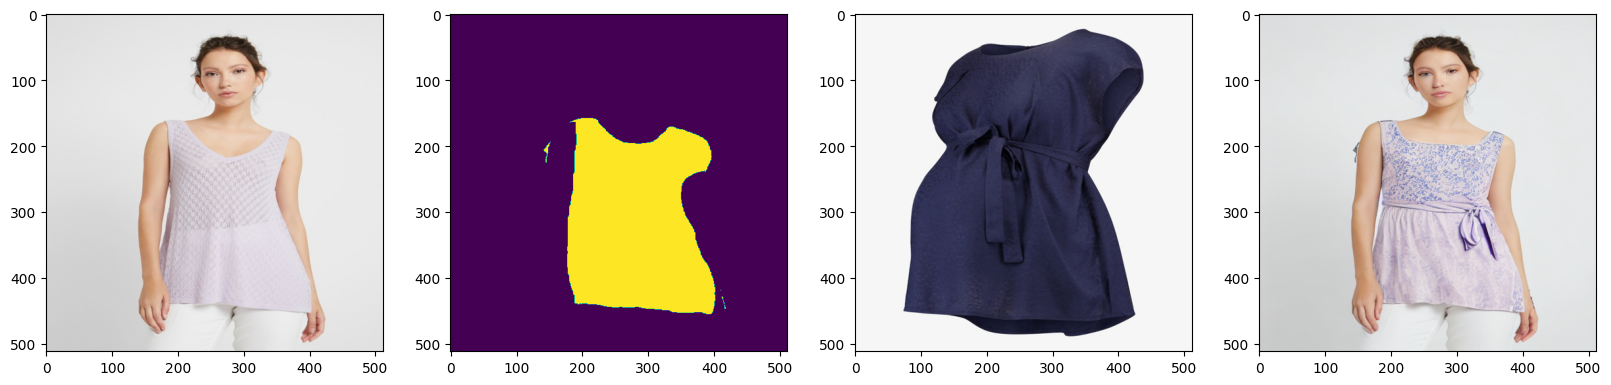

a women's white t - shirt with yellow stripes, foil effect, ascii, laurie, cg original, alter, easy, munkácsy, pieces, frontal picture


  0%|          | 0/16 [00:00<?, ?it/s]

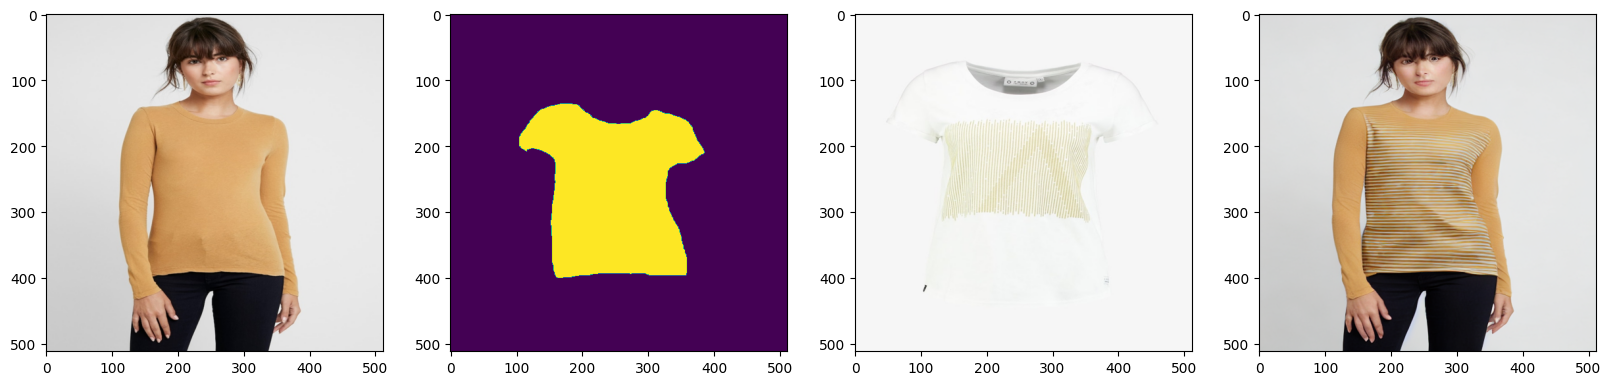

In [56]:
for i in range(5):
    image = Image.open(f"../data/test_cases/image_{i}.png").resize((512, 512))
    mask = Image.open(f"../data/test_cases/warped_cloth_mask_{i}.png").resize((512, 512), Image.NEAREST)
    prompt = cloth_descriptions[i]
    print(prompt)
    controlnet_conditioning_image = image_to_seg(image)
    
#     image = np.array(image)
#     image[np.array(mask) != 0] = 0
#     image = Image.fromarray(image)
    
    res_image = pipe(prompt, image, mask, controlnet_conditioning_image, num_inference_steps=20).images[0]
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 16))
    ax[0].imshow(image)
    ax[1].imshow(mask)
    ax[2].imshow(Image.open(f"../data/test_cases/cloth_{i}.png").resize((512, 512)))
    ax[3].imshow(res_image)
    plt.show()